In [2]:
import random

import pandas as pd
import numpy as np
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import random
import tqdm
import pickle

/home/tristan/Documents/urba/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_247084/601272036.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migrati

In [9]:
limitedDataset = pd.read_csv("./data/limtedDataSet.csv", index_col=0)
limitedDataset.head()

,lat,long,time,userNumber
0,39.984702,116.318417,1.224730e+09,0
1,39.984288,116.299943,1.224731e+09,0
2,39.983557,116.299235,1.224731e+09,0
3,39.995777,116.286798,1.224735e+09,0
4,39.996832,116.285446,1.224735e+09,0


In [4]:
limitedDataset.describe()

,lat,long,time,userNumber
count,697279.000000,697279.000000,6.972790e+05,697279.000000
mean,39.080813,112.287790,1.242473e+09,79.266674
std,3.915662,28.275930,3.058664e+07,56.977834
min,1.044024,-179.969593,9.467683e+08,0.000000
25%,39.909022,116.307058,1.225447e+09,25.000000
50%,39.975403,116.338408,1.236690e+09,68.000000
75%,40.006018,116.431037,1.247633e+09,128.000000
max,400.166667,179.996942,1.343378e+09,181.000000


In [10]:
graphdata = limitedDataset[(limitedDataset.lat > 38) & (limitedDataset.lat < 41)]


In [11]:
graphdata = graphdata[(graphdata.long > 114) & (graphdata.long < 118)]

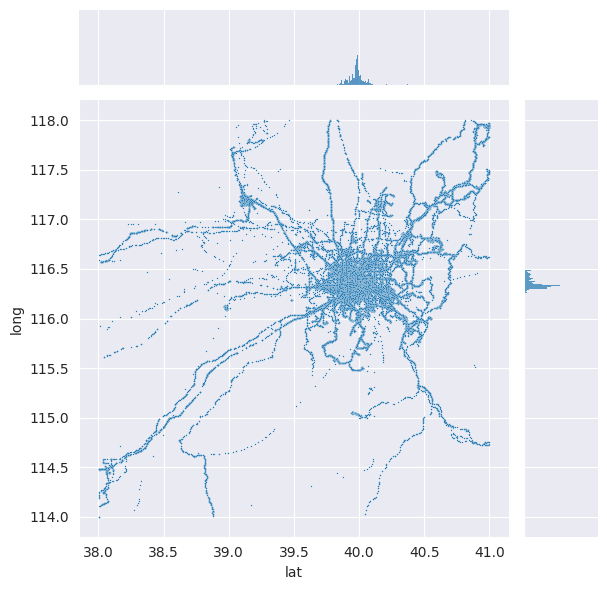

In [12]:
seaborn.jointplot(x='lat', y='long', data=graphdata, kind = "scatter" , s=1)

In [53]:
def getclusternumber(locationnp: np.array):
    kms_per_radian = 6371.0088
    epsilon = 1.5 / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(locationnp))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([locationnp[cluster_labels == n] for n in range(num_clusters)])
    #print('Number of clusters: {}'.format(num_clusters))
    return [num_clusters, clusters]

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def get_trajectories(points: pd.DataFrame, numberOftrajectories:int, approxNumbPlaces: int):
    trjacetories = []
    for x in range(0,numberOftrajectories,1):
        # contition number of stop cannot be larger then the total number of importatnt point
        numberstops = random.randint(2,approxNumbPlaces)
        if  numberstops > points.shape[0]:
            numberstops = points.shape[0]

        listindex = random.sample(range(0, points.shape[0]),  numberstops )
        locations = []
        for i in listindex:
            locations.append(points.loc[i, ['lat','long']].to_list())
        trjacetories.append(locations)
    return trjacetories


In [85]:
alltraj = []
numberoftrjacectectories = 10
approxNumbStops = 3

for name, group in tqdm.tqdm(limitedDataset.groupby("userNumber")):
    # remove lat long that are out of the city
    group = group[(group.lat < 90) & (group.lat > -90)]
    numb_cust, clusters = getclusternumber(group[['lat','long']].values)
    center_points = clusters.map(get_centermost_point)
    lats, lons = zip(*center_points)
    rep_points = pd.DataFrame({'lat':lats, 'long':lons})
    alltraj.extend(get_trajectories(rep_points, numberoftrjacectectories, approxNumbStops))




100%|██████████| 182/182 [00:48<00:00,  3.72it/s]


In [96]:
alltraj

[[[39.839594, 116.223596], [39.922623, 116.711158], [31.109247, 121.050374]],
 [[40.109356, 116.478451], [39.908065, 116.55479], [39.943923, 116.786784]],
 [[31.137242, 121.123875], [31.149603, 121.252908], [39.784267, 116.283593]],
 [[39.920301, 116.634649], [39.999495, 116.333188]],
 [[40.109356, 116.478451], [31.246023, 121.462283], [39.8833, 116.456283]],
 [[39.920301, 116.634649], [39.999495, 116.333188]],
 [[31.272436, 121.475591], [40.109356, 116.478451]],
 [[39.920301, 116.634649], [31.159137, 121.301923], [39.922623, 116.711158]],
 [[31.246023, 121.462283], [31.288644, 121.40025], [31.159137, 121.301923]],
 [[31.270581, 121.388339], [31.246023, 121.462283]],
 [[39.995033, 116.323111], [39.907976, 116.411265]],
 [[39.907976, 116.411265], [39.995033, 116.323111]],
 [[39.907976, 116.411265], [39.995033, 116.323111]],
 [[39.907976, 116.411265], [39.995033, 116.323111]],
 [[39.907976, 116.411265], [39.995033, 116.323111]],
 [[39.907976, 116.411265], [39.995033, 116.323111]],
 [[39.

In [97]:
with open("./data/trajectories.pkl","wb") as f:
    pickle.dump(alltraj, f)

ValueError: 1 columns passed, passed data had 3 columns